In [1]:
!pip install bitmex
!pip install python-binance
!pip install keras_multi_head
!pip install requests --upgrade
!pip install sktime
!pip install keras-self-attention
!pip install tsmoothie
!pip install pandas
!pip install pandas_datareader
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.7 MB/s eta 0:00:00
  Created wheel for bravado-core: filename=bravado_core-6.1.1-py2.py3-none-any.whl size=67675 sha256=67fae8aae57a0e155db44f6e601fe6908ffa6ecda1a4f6374b424de7e7629025
  Stored in directory: /root/.cache/pip/wheels/cf/d7/1c/1d707a21e0a0323bdbfbb2f6de125ae6bb70d62aa2838df321
Successfully built bravado-core
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.7/113.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 44.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for keras_multi_head: filename=keras_multi_head-0.29.0-py3-none-any.whl size=149

In [2]:
import keras
from google.colab import files
from keras import Sequential
from keras.metrics import RootMeanSquaredError
from keras.layers import Conv1D, Dropout, AveragePooling1D, LSTM, RepeatVector, TimeDistributed, Dense, MaxPooling1D
#from keras.layers import Sequential, Conv1D, Dropout, AveragePooling1D, LSTM, RepeatVector, TimeDistributed, Dense, RootMeanSquaredError

In [3]:
# IMPORTS
import requests
import tsmoothie
from tsmoothie.utils_func import sim_randomwalk
from tsmoothie.smoother import LowessSmoother, ExponentialSmoother
import matplotlib.pyplot as plt
import pandas as pd
import math
import os.path
import time
from bitmex import bitmex
from binance.client import Client
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook #(Optional, used for progress-bars)
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
import tensorflow as tf
from keras_multi_head import MultiHeadAttention
import pandas
from pandas_datareader import data as pdr
import yfinance as yfin
from keras import backend as K
from sktime.transformations.series.boxcox import BoxCoxTransformer, LogTransformer
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.transformations.series.detrend import Detrender
from keras_self_attention import SeqSelfAttention

### API
bitmex_api_key = 'QJztZ3vF61eSlyYdDe1xnCrL'    #Enter your own API-key here
bitmex_api_secret = 'iV05s1WvMdagCcerBaW-OglyS5DR41KEM7ti148vG67-lwA7' #Enter your own API-secret here
binance_api_key = 'buEUMq3Qo5LaTwCOKl4vFJG1fe9kCmJtOtXOaPlpr7wgtF3iwXiVC3yKPFLTviyO'    #Enter your own API-key here
binance_api_secret = 'lpHoAXrM2n42H9W2cOlnQUD1zckp1v6PiaCjQuLdgoPrCJ4jaBA8NGHxDd4OodSA' #Enter your own API-secret here

### CONSTANTS
binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440}
batch_size = 1000
bitmex_client = bitmex(test=False, api_key=bitmex_api_key, api_secret=bitmex_api_secret)
#binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)


### FUNCTIONS
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime('1 Jan 2017', '%d %b %Y')
    elif source == "bitmex": old = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=False).result()[0][0]['timestamp']
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    if source == "bitmex": new = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=True).result()[0][0]['timestamp']
    return old, new


def get_crypto_price(symbol, exchange, start_date = None):
    api_key = 'RC2YY8JWEUDMY6IW'
    api_url = f'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={symbol}&market={exchange}&apikey={api_key}'
    raw_df = requests.get(api_url).json()
    print(raw_df)
    df = pd.DataFrame(raw_df['Time Series (Digital Currency Daily)']).T
    df = df.rename(columns = {'1a. open (USD)': 'open', '2a. high (USD)': 'high', '3a. low (USD)': 'low', '4a. close (USD)': 'close', '5. volume': 'volume'})
    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['1b. open (USD)', '2b. high (USD)', '3b. low (USD)', '4b. close (USD)', '6. market cap (USD)'], axis = 1)
    if start_date:
        df = df[df.index >= start_date]
    return df


#def get_all_binance(symbol, kline_size, save = False):
#    filename = '%s-%s-data.csv' % (symbol, kline_size)
#    if os.path.isfile(filename): data_df = pd.read_csv(filename)
#    else: data_df = pd.DataFrame()
#    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
#    delta_min = (newest_point - oldest_point).total_seconds()/60
#    available_data = math.ceil(delta_min/binsizes[kline_size])
#    if oldest_point == datetime.strptime('1 Jan 2017', '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
#    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
#    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
#    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
#    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
#    if len(data_df) > 0:
#        temp_df = pd.DataFrame(data)
#        data_df = data_df.append(temp_df)
#    else: data_df = data
#    data_df.set_index('timestamp', inplace=True)
#    if save: data_df.to_csv(filename)
#    print('All caught up..!')
#    return data_df

def get_all_bitmex(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "bitmex")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    rounds = math.ceil(available_data / batch_size)
    if rounds > 0:
        print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data in %d rounds.' % (delta_min, symbol, available_data, kline_size, rounds))
        for round_num in tqdm_notebook(range(rounds)):
            time.sleep(1)
            new_time = (oldest_point + timedelta(minutes = round_num * batch_size * binsizes[kline_size]))
            data = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=batch_size, startTime = new_time).result()[0]
            temp_df = pd.DataFrame(data)
            data_df = data_df.append(temp_df)
    data_df.set_index('timestamp', inplace=True)
    if save and rounds > 0: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df

/usr/local/lib/python3.11/dist-packages/swagger_spec_validator/validator20.py:49: SwaggerValidationWarning: Found "$ref: #/definitions/UserPreferences" with siblings that will be overwritten. See https://stackoverflow.com/a/48114924 for more information. (path #/definitions/User/properties/preferences)
  warnings.warn(


In [4]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [5]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('loss') <= 1e-3:
            self.model.stop_training = True

In [6]:
import numpy as np
from tsmoothie.utils_func import sim_randomwalk
from tsmoothie.smoother import LowessSmoother

def getOutliers(data, df, lookback):
  outlier_points = []

  # Use ExponentialSmoother with 'sigma_interval'
  smoother = ExponentialSmoother(window_len=20, alpha=0.2)
  smoother.smooth(data)

  # Get sigma intervals
  low, up = smoother.get_intervals('sigma_interval', n_sigma=2)  # Use n_sigma to control interval width

  points = smoother.data[0]
  up_points = up[0]
  low_points = low[0]

  for i in range(len(points)-1, 0, -1):
      current_point = points[i]
      current_up = up_points[i]
      current_low = low_points[i]
      if current_point > current_up or current_point < current_low:
          outlier_points.append(i)
          print(f'found an outlier value: {current_point}')

  # Instead of hardcoded values, you can use statistical measures like standard deviation
  # to identify potential spike ranges:
  std_dev = np.std(points)
  spike_threshold = 2 * std_dev  # Adjust as needed

  first_check_spike_points = []
  for i in range(len(outlier_points)):
    if i >= 1 and (outlier_points[i] - outlier_points[i-1]) < 8:
      first_check_spike_points.append(outlier_points[i])
      first_check_spike_points.append(outlier_points[i-1])

  first_check_spike_points = list(set(first_check_spike_points))
  first_check_spike_points.sort()

  given_ranges = []
  for i in range(len(first_check_spike_points) - 1):
    temp = []
    temp.append(first_check_spike_points[i])
    temp.append(first_check_spike_points[i+1])
    given_ranges.append(temp)

  given_ranges = first_check_spike_points
  interval_dates = []

  eps = 1e-9
  df['spike_outlier'] = eps
  for i in given_ranges:
    for k in range(5):
      if (i+k) < len(df):
        df['spike_outlier'].iloc[i+k] = 1
        df['spike_outlier'].iloc[i-k] = 1

  return df

In [7]:
from tensorflow.python.client import device_lib
import keras
import tensorflow as tf
from tensorflow.python.keras import backend as K

print(tf.test.gpu_device_name()) # string
print(tf.test.is_gpu_available()) # True/False
print(device_lib.list_local_devices()) # list of DeviceAttributes (contains CPUs, GPUs and XLA_CPU and XLA_GPU)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


/device:GPU:0
True
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 303162745070211243
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6425708187090244215
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [8]:
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 1} )
sess = tf.compat.v1.Session(config=config)
K.set_session(sess)

In [9]:
import math
mse = tf.keras.losses.MeanSquaredError()


def time_weighted_loss(y_true, y_pred, alpha=0.75):
  """
  Calculates the time-weighted loss, giving more importance to recent errors.

  Args:
      y_true: Ground truth values.
      y_pred: Predicted values.
      alpha: Decay factor (0 < alpha < 1), controlling the weight of past errors.

  Returns:
      The time-weighted loss value.
  """
  # Calculate the squared errors
  errors = tf.square(y_true - y_pred)

  # Create weights based on time (more recent errors get higher weights)
  num_timesteps = tf.shape(errors)[1]
  weights = tf.pow(alpha, tf.cast(tf.range(num_timesteps - 1, -1, -1), dtype=tf.float32))
  weights = tf.reshape(weights, (1, num_timesteps, 1))

  # Apply the weights to the errors
  weighted_errors = weights * errors

  # Calculate the mean weighted loss
  loss = tf.reduce_mean(weighted_errors)

  # Calculate MSE for the close value (assuming close value is at index 3)
  mse_close = K.mean(K.square(y_true[:, :, 3] - y_pred[:, :, 3]))
  mse_close1 = K.mean(K.square(y_true - y_pred))
  # Combine the metrics (e.g., weighted average)
  combined_value = 0.6 * loss + 0.3 * mse_close  + 0.1 * mse_close1
  return combined_value


def custom_metric(y_true, y_pred, alpha=0.8, up_weight=1.5):
    """
    Custom metric combining directional accuracy and time-weighted emphasis on recent performance,
    with higher weight for upward movements.

    Args:
        y_true: Ground truth values.
        y_pred: Predicted values.
        alpha: Decay factor for time-weighted component (0 < alpha < 1).
        up_weight: Weight assigned to upward movements.

    Returns:
        The custom metric value.
    """
    # Directional Accuracy Component (with up_weight)
    y_true_diff = y_true[:, 1:] - y_true[:, :-1]
    y_pred_diff = y_pred[:, 1:] - y_pred[:, :-1]
    y_true_directions = tf.sign(y_true_diff)
    y_pred_directions = tf.sign(y_pred_diff)

    # Apply up_weight to upward movements
    weights = tf.where(y_true_directions > 0, up_weight, 1.0)  # Default weight for other movements is 1.0

    match_count = tf.reduce_sum(tf.cast(tf.equal(y_true_directions, y_pred_directions), dtype='float32') * weights)
    total_count = tf.reduce_sum(weights)
    directional_accuracy = match_count / (total_count + K.epsilon())  # Add K.epsilon() to the denominator

     # --- Weighted Least Mean Squares ---
    num_timesteps = tf.shape(y_true)[1]
    weights = tf.pow(alpha, tf.cast(tf.range(num_timesteps - 1, -1, -1), dtype=tf.float32))  # Exponential decay weights
    weights = tf.reshape(weights, (1, num_timesteps, 1))

    weighted_errors = weights * tf.square(y_true - y_pred)  # Weighted squared errors
    weighted_mse = tf.reduce_mean(weighted_errors)

    # --- Combine the Metrics ---
    combined_metric = directional_accuracy - weighted_mse  # You can adjust the combination as needed

    return combined_metric


def getStandardTesting(stock, exchange, dict_output, lookback, iteration, prediction):
  outlier_points = []
  symbol = stock
  crypto = stock + '-' + exchange
  #yfin.pdr_override()
  #data = pdr.get_data_yahoo(crypto, start=startdate, end=enddate)
  data = yfin.download(
    tickers = crypto,
    period = "max",
    interval = "1h"
    )
  df = data[['Open', 'High', 'Low', 'Close', 'Volume']]
  df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
  eps = 1e-9
  df['Open'] = df['Open'].astype('float32') + eps
  df['High'] = df['High'].astype('float32') + eps
  df['Low'] = df['Low'].astype('float32') + eps
  df['Close'] = df['Close'].astype('float32') + eps
  df['Volume'] = df['Volume'].astype('float32') + eps

  one_hot1 = pd.get_dummies(pd.DatetimeIndex(df.index).month.astype('int'))
  one_hot2 = pd.get_dummies(pd.DatetimeIndex(df.index).day.astype('int'))
  one_hot3 = pd.get_dummies(pd.DatetimeIndex(df.index).hour.astype('int'))
  one_hot4 = pd.get_dummies(pd.DatetimeIndex(df.index).minute.astype('int'))
  # Drop column B as it is now encoded
  # Join the encoded df
  df = df.reset_index()
  df = pd.concat([df, one_hot1, one_hot2, one_hot3, one_hot4], axis=1)
  if(len(df) < lookback):
    return(dict_output)
  df = df.drop("Datetime", axis=1)
  print(df)

  data = df['Close'].values.reshape(1, -1)
  df['Close_MA_24'] = df['Close'].rolling(window=24).mean()
  df['Close_MA_48'] = df['Close'].rolling(window=48).mean()
  df['Close_MA_72'] = df['Close'].rolling(window=72).mean()
  df['Close_MA_168'] = df['Close'].rolling(window=168).mean()
  df['Close_MA_720'] = df['Close'].rolling(window=720).mean()
  df['Close_MA_1440'] = df['Close'].rolling(window=1440).mean()

  df['Volume_MA_24'] = df['Volume'].rolling(window=24).mean()
  df['Volume_MA_48'] = df['Volume'].rolling(window=48).mean()
  df['Volume_MA_72'] = df['Volume'].rolling(window=72).mean()
  df['Volume_MA_168'] = df['Volume'].rolling(window=168).mean()
  df['Volume_MA_720'] = df['Volume'].rolling(window=720).mean()
  df['Volume_MA_1440'] = df['Volume'].rolling(window=1440).mean()


  df = getOutliers(data, df, lookback)
  df = df.fillna(0) + eps
  overall_df = df

  compare_df = pd.DataFrame()
  compare_df['Actual'] = df[-1*prediction:]['Close'].tolist()
  print(compare_df)

  train = overall_df[:(-1*lookback)-(prediction+1)]
  scalers={}
  for i in ['Open', 'High', 'Low', 'Close', 'Volume', 'Close_MA_24', 'Close_MA_48', 'Close_MA_72', 'Close_MA_168', 'Close_MA_720', 'Close_MA_1440', 'Volume_MA_24', 'Volume_MA_48', 'Volume_MA_72', 'Volume_MA_168', 'Volume_MA_720', 'Volume_MA_1440']:
      scaler = Pipeline([('boxcox', BoxCoxTransformer()), ('scaler', StandardScaler()), ('max', MinMaxScaler(feature_range=(-1,1)))]) #MinMaxScaler()
      s_s = scaler.fit(df[:(-1*lookback)-(prediction+1)][i].values.reshape(-1,1))
      s_s = scaler.transform(train[i].values.reshape(-1,1))
      s_s=np.reshape(s_s,len(s_s))
      scalers['scaler_'+ i] = scaler
      train[i]=s_s
  test = overall_df[(-1*lookback)-(prediction+1):-1*prediction]
  for i in ['Open', 'High', 'Low', 'Close', 'Volume', 'Close_MA_24', 'Close_MA_48', 'Close_MA_72', 'Close_MA_168', 'Close_MA_720', 'Close_MA_1440', 'Volume_MA_24', 'Volume_MA_48', 'Volume_MA_72', 'Volume_MA_168', 'Volume_MA_720', 'Volume_MA_1440']:
      scaler = scalers['scaler_'+i]
      s_s = scaler.transform(test[i].values.reshape(-1,1))
      s_s=np.reshape(s_s,len(s_s))
      scalers['scaler_'+i] = scaler
      test[i]=s_s

  n_past = lookback
  n_future = 1
  n_features = 18+len(one_hot1.columns)+len(one_hot2.columns)+len(one_hot3.columns) + len(one_hot4.columns)

  X_train, y_train = split_series(train.values, n_past, n_future)
  X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
  y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
  X_test, y_test = split_series(test.values, n_past, n_future)
  X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
  y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

  X_train = np.asarray(X_train).astype('float32')
  y_train = np.asarray(y_train).astype('float32')
  X_test = np.asarray(X_test).astype('float32')
  y_test = np.asarray(y_test).astype('float32')

  filepath_save = "%s_%s.weights.h5" % (stock, exchange)
  batch_size1 = int(len(df) / 30)

  model_e1d1 = Sequential()
  model_e1d1.add(Conv1D(filters=1024, kernel_size=7,    # Standard 128
                                strides=1, padding='causal',
                                activation="relu",
                                input_shape=(None, n_features)))
  model_e1d1.add(Dropout(0.2))
  model_e1d1.add(MaxPooling1D(pool_size=3))
  model_e1d1.add(LSTM(1500, dropout=0.2, recurrent_dropout=0.2, input_shape=(n_past, n_features)))
  model_e1d1.add(RepeatVector(n_future))
  model_e1d1.add(MultiHeadAttention(
      head_num=6,
      name='Multi-Head',
  ))
  model_e1d1.add(LSTM(1500, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
  model_e1d1.add(TimeDistributed(Dense(n_features, activation='linear')))
  #model_e1d1.load_weights(filepath_save)
  model_e1d1.summary()

  x = 1500
  y = 2e-3
  z = 1
  #optimizer = keras.optimizers.Adamax(lr=x*y*z)
  model_checkpoint_callback_e1d1 = tf.keras.callbacks.ModelCheckpoint(filepath=filepath_save, save_weights_only=True, monitor='val_custom_metric',save_best_only=True)
  callback = keras.callbacks.EarlyStopping(monitor='val_custom_metric', min_delta=0.001, patience=10000)
  reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: y * z ** x)
  model_e1d1.compile(optimizer='Nadam', loss=time_weighted_loss, metrics=[custom_metric], run_eagerly=True)
  history_e1d1=model_e1d1.fit(X_train,y_train,shuffle=True,epochs=iteration,validation_data=(X_test,y_test),batch_size=batch_size1,verbose=1,callbacks=[reduce_lr, model_checkpoint_callback_e1d1])


  test2 = X_test
  final_values_non_spike = np.zeros(shape=(prediction,18+len(one_hot1.columns)+len(one_hot2.columns)+len(one_hot3.columns)+len(one_hot4.columns)))
  for i in range(prediction):
    pred_e1d1=model_e1d1.predict(test2)
    for j in range(lookback):
      if j != (lookback-1):
        test2[0][j] = test2[0][j+1]
      else:
        test2[0][j] = pred_e1d1[0]

    final_values_non_spike[i] = pred_e1d1[0]


  final_values_non_spike = np.array([final_values_non_spike])

  pred_e1d1 = final_values_non_spike
  for index,i in enumerate(df.columns):
    if i in ['Open', 'High', 'Low', 'Close', 'Volume', 'Close_MA_24', 'Close_MA_48', 'Close_MA_72', 'Close_MA_168', 'Close_MA_720', 'Close_MA_1440', 'Volume_MA_24', 'Volume_MA_48', 'Volume_MA_72', 'Volume_MA_168', 'Volume_MA_720', 'Volume_MA_1440']:
      scaler = scalers['scaler_'+i]
      pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index].reshape(-1,1)).reshape(1,-1)
      #y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
      #y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

  final_df = pd.DataFrame(pred_e1d1[0])

  months = [i for i in range(len(one_hot1.columns))]
  days = [i for i in range(len(one_hot2.columns))]
  hours = [i for i in range(len(one_hot3.columns))]
  minutes = [i for i in range(len(one_hot4.columns))]
  days_of_week = [i for i in range(2)]
  final_df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'spike_outlier', 'Close_MA_24', 'Close_MA_48', 'Close_MA_72', 'Close_MA_168', 'Close_MA_720', 'Close_MA_1440', 'Volume_MA_24', 'Volume_MA_48', 'Volume_MA_72', 'Volume_MA_168', 'Volume_MA_720', 'Volume_MA_1440'] + months + days + hours + minutes
  print(final_df)

  compare_df['Predicted'] = final_df['Close'].tolist()
  print(compare_df)

  dict_output[crypto] = (df['Close'].iloc[-1], final_df['Close'].max())

  plt.plot(list(range(prediction)), compare_df['Actual'].tolist())
  plt.plot(list(range(prediction)), compare_df['Predicted'].tolist())
  plt.title('title')
  plt.ylabel('ylabel')
  plt.xlabel('xlabel')
  plt.legend()
  plt.savefig("train_validate_%s_%s.pdf" % (stock, exchange))
  plt.show()

  print(dict_output)

In [10]:
import warnings
import time
warnings.filterwarnings('ignore')

#dict_output = {}
#dict_output = getStandardTesting("XWG", "USD", dict_output, 24, 200, 1440)
#time.sleep(5)
#files.download("train_validate_%s_%s.pdf" % ("XWG", "USD"))

In [11]:
def getFuturePrices(stock, exchange, dict_output, lookback, iteration, prediction):
  outlier_points = []
  symbol = stock
  crypto = stock + '-' + exchange
  #yfin.pdr_override()
  #data = pdr.get_data_yahoo(crypto, start=startdate, end=enddate)
  data = yfin.download(
    tickers = crypto,
    period = "max",
    interval = "1h"
    )
  df = data[['Open', 'High', 'Low', 'Close', 'Volume']]
  df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
  eps = 1e-9
  df['Open'] = df['Open'].astype('float32') + eps
  df['High'] = df['High'].astype('float32') + eps
  df['Low'] = df['Low'].astype('float32') + eps
  df['Close'] = df['Close'].astype('float32') + eps
  df['Volume'] = df['Volume'].astype('float32') + eps

  one_hot1 = pd.get_dummies(pd.DatetimeIndex(df.index).month.astype('int'))
  one_hot2 = pd.get_dummies(pd.DatetimeIndex(df.index).day.astype('int'))
  one_hot3 = pd.get_dummies(pd.DatetimeIndex(df.index).hour.astype('int'))
  one_hot4 = pd.get_dummies(pd.DatetimeIndex(df.index).minute.astype('int'))
  # Drop column B as it is now encoded
  # Join the encoded df
  df = df.reset_index()
  df = pd.concat([df, one_hot1, one_hot2, one_hot3, one_hot4], axis=1)
  if(len(df) < lookback):
    return(dict_output)
  df = df.drop("Datetime", axis=1)
  print(df)

  data = df['Close'].values.reshape(1, -1)
  df['Close_MA_24'] = df['Close'].rolling(window=24).mean()
  df['Close_MA_48'] = df['Close'].rolling(window=48).mean()
  df['Close_MA_72'] = df['Close'].rolling(window=72).mean()
  df['Close_MA_168'] = df['Close'].rolling(window=168).mean()
  df['Close_MA_720'] = df['Close'].rolling(window=720).mean()
  df['Close_MA_1440'] = df['Close'].rolling(window=1440).mean()

  df['Volume_MA_24'] = df['Volume'].rolling(window=24).mean()
  df['Volume_MA_48'] = df['Volume'].rolling(window=48).mean()
  df['Volume_MA_72'] = df['Volume'].rolling(window=72).mean()
  df['Volume_MA_168'] = df['Volume'].rolling(window=168).mean()
  df['Volume_MA_720'] = df['Volume'].rolling(window=720).mean()
  df['Volume_MA_1440'] = df['Volume'].rolling(window=1440).mean()

  df = getOutliers(data, df, lookback)
  df = df.fillna(0) + eps
  overall_df = df

  #compare_df = pd.DataFrame()
  #compare_df['Actual'] = df[-1*prediction:]['Close'].tolist()
  #print(compare_df)

  train = overall_df[:(-1*lookback)-1]
  scalers={}
  for i in ['Open', 'High', 'Low', 'Close', 'Volume', 'Close_MA_24', 'Close_MA_48', 'Close_MA_72', 'Close_MA_168', 'Close_MA_720', 'Close_MA_1440', 'Volume_MA_24', 'Volume_MA_48', 'Volume_MA_72', 'Volume_MA_168', 'Volume_MA_720', 'Volume_MA_1440']:
      scaler = Pipeline([('boxcox', BoxCoxTransformer()), ('scaler', StandardScaler()), ('max', MinMaxScaler(feature_range=(-1,1)))]) #MinMaxScaler()
      s_s = scaler.fit(df[:(-1*lookback)-(prediction+1)][i].values.reshape(-1,1))
      s_s = scaler.transform(train[i].values.reshape(-1,1))
      s_s=np.reshape(s_s,len(s_s))
      scalers['scaler_'+ i] = scaler
      train[i]=s_s
  test = overall_df[(-1*lookback)-1:]
  for i in ['Open', 'High', 'Low', 'Close', 'Volume', 'Close_MA_24', 'Close_MA_48', 'Close_MA_72', 'Close_MA_168', 'Close_MA_720', 'Close_MA_1440', 'Volume_MA_24', 'Volume_MA_48', 'Volume_MA_72', 'Volume_MA_168', 'Volume_MA_720', 'Volume_MA_1440']:
      scaler = scalers['scaler_'+i]
      s_s = scaler.transform(test[i].values.reshape(-1,1))
      s_s=np.reshape(s_s,len(s_s))
      scalers['scaler_'+i] = scaler
      test[i]=s_s

  n_past = lookback
  n_future = 1
  n_features = 18+len(one_hot1.columns)+len(one_hot2.columns)+len(one_hot3.columns) + len(one_hot4.columns)

  X_train, y_train = split_series(train.values, n_past, n_future)
  X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
  y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
  X_test, y_test = split_series(test.values, n_past, n_future)
  X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
  y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

  X_train = np.asarray(X_train).astype('float32')
  y_train = np.asarray(y_train).astype('float32')
  X_test = np.asarray(X_test).astype('float32')
  y_test = np.asarray(y_test).astype('float32')

  filepath_save = "%s_%s.weights.h5" % (stock, exchange)
  batch_size1 = int(len(df) / 30)

  model_e1d1 = Sequential()
  model_e1d1.add(Conv1D(filters=1024, kernel_size=7,    # Standard 128
                                strides=1, padding='causal',
                                activation="relu",
                                input_shape=(None, n_features)))
  model_e1d1.add(Dropout(0.2))
  model_e1d1.add(MaxPooling1D(pool_size=3))
  model_e1d1.add(LSTM(1500, dropout=0.2, recurrent_dropout=0.2, input_shape=(n_past, n_features)))
  model_e1d1.add(RepeatVector(n_future))
  model_e1d1.add(MultiHeadAttention(
      head_num=6,
      name='Multi-Head',
  ))
  model_e1d1.add(LSTM(1500, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
  model_e1d1.add(TimeDistributed(Dense(n_features, activation='linear')))
  model_e1d1.load_weights(filepath_save)
  model_e1d1.summary()

  x = 1500
  y = 2e-3
  z = 1
  #optimizer = keras.optimizers.Adamax(lr=x*y*z)
  model_checkpoint_callback_e1d1 = tf.keras.callbacks.ModelCheckpoint(filepath=filepath_save, save_weights_only=True, monitor='val_custom_metric',save_best_only=True)
  callback = keras.callbacks.EarlyStopping(monitor='val_custom_metric', min_delta=0.001, patience=10000)
  reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: y * z ** x)
  model_e1d1.compile(optimizer='Nadam', loss=time_weighted_loss, metrics=[custom_metric], run_eagerly=True)
  history_e1d1=model_e1d1.fit(X_train,y_train,shuffle=True,epochs=iteration,validation_data=(X_test,y_test),batch_size=batch_size1,verbose=1,callbacks=[reduce_lr, model_checkpoint_callback_e1d1])


  test2 = X_test
  final_values_non_spike = np.zeros(shape=(prediction,18+len(one_hot1.columns)+len(one_hot2.columns)+len(one_hot3.columns)+len(one_hot4.columns)))
  for i in range(prediction):
    pred_e1d1=model_e1d1.predict(test2)
    for j in range(lookback):
      if j != (lookback-1):
        test2[0][j] = test2[0][j+1]
      else:
        test2[0][j] = pred_e1d1[0]

    final_values_non_spike[i] = pred_e1d1[0]


  final_values_non_spike = np.array([final_values_non_spike])

  pred_e1d1 = final_values_non_spike
  for index,i in enumerate(df.columns):
    if i in ['Open', 'High', 'Low', 'Close', 'Volume', 'Close_MA_24', 'Close_MA_48', 'Close_MA_72', 'Close_MA_168', 'Close_MA_720', 'Close_MA_1440', 'Volume_MA_24', 'Volume_MA_48', 'Volume_MA_72', 'Volume_MA_168', 'Volume_MA_720', 'Volume_MA_1440']:
      scaler = scalers['scaler_'+i]
      pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index].reshape(-1,1)).reshape(1,-1)
      #y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
      #y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

  final_df = pd.DataFrame(pred_e1d1[0])

  months = [i for i in range(len(one_hot1.columns))]
  days = [i for i in range(len(one_hot2.columns))]
  hours = [i for i in range(len(one_hot3.columns))]
  minutes = [i for i in range(len(one_hot4.columns))]
  days_of_week = [i for i in range(2)]
  final_df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'spike_outlier', 'Close_MA_24', 'Close_MA_48', 'Close_MA_72', 'Close_MA_168', 'Close_MA_720', 'Close_MA_1440', 'Volume_MA_24', 'Volume_MA_48', 'Volume_MA_72', 'Volume_MA_168', 'Volume_MA_720', 'Volume_MA_1440'] + months + days + hours + minutes
  print(final_df)

  dict_output[crypto] = (df['Close'].iloc[-1], final_df['Close'].max())

  plt.plot(list(range(prediction)), final_df['Close'].tolist())
  plt.title('title')
  plt.ylabel('ylabel')
  plt.xlabel('xlabel')
  plt.legend()
  plt.savefig("forecasting_%s_%s.pdf" % (stock, exchange))
  plt.show()

  print(dict_output)

In [12]:
#dict_output = {}
#dict_output = getFuturePrices('XWG', 'USD', dict_output, 24, 10, 1440)
#time.sleep(5)
#files.download("forecasting_%s_%s.pdf" % ("XWG", "USD"))

In [13]:
import requests

api_key = '6b1cf277-f71d-4408-9904-6666e5fce0e8'

cryptos = []
url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'

for start in range(1, 20000, 5000):

    params = {
        'start': start,
        'limit': 5000,
    }

    headers = {
        'Accepts': 'application/json',
        'X-CMC_PRO_API_KEY': api_key
    }

    r = requests.get(url, params=params, headers=headers)
    data = r.json()

    for number, item in enumerate(data['data']):
        print(f"{start+number:4} | {item['symbol']:5} | {item['date_added'][:10]}")
        cryptos.append(item['symbol'])


Streaming output truncated to the last 5000 lines.
5710 | OMNI  | 2025-01-10
5711 | PEGA  | 2024-07-19
5712 | LANDWOLF | 2024-04-12
5713 | ONI   | 2022-01-24
5714 | EMON  | 2021-05-18
5715 | MEMES | 2024-01-11
5716 | HSUI  | 2024-02-15
5717 | KEN   | 2024-08-02
5718 | ASTRADAO | 2023-01-13
5719 | TELE  | 2022-03-24
5720 | TRIVIA | 2022-07-02
5721 | WORKIE | 2024-12-13
5722 | TOKU  | 2024-06-20
5723 | HADES | 2023-02-05
5724 | RAGE  | 2024-08-14
5725 | LYUM  | 2023-06-30
5726 | NAMI  | 2024-10-08
5727 | LIQ   | 2021-07-22
5728 | GEMSTON | 2023-10-26
5729 | DFUND | 2024-12-24
5730 | BENGY | 2025-01-13
5731 | TYLER | 2024-12-13
5732 | FREN  | 2023-12-27
5733 | MBC   | 2024-04-01
5734 | BCOQ  | 2024-03-19
5735 | XDOGE | 2021-10-20
5736 | GEMS  | 2022-04-27
5737 | BLXM  | 2021-10-22
5738 | DOGECUBE | 2023-03-14
5739 | TOPG  | 2024-06-09
5740 | RIZE  | 2022-03-01
5741 | RXCG  | 2021-11-29
5742 | HODI  | 2024-12-10
5743 | GROOVE | 2024-07-01
5744 | BFT   | 2022-09-26
5745 | KUNAI | 2024-03-18

AUR


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AUR-BTC']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AUR-BTC']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


AUR


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AUR-ETH']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AUR-ETH']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


AUR


[*********************100%***********************]  1 of 1 completed


           Open      High       Low     Close        Volume     1      2  \
0      0.027124  0.027200  0.026870  0.026928  1.000000e-09  True  False   
1      0.026916  0.026964  0.026864  0.026964  1.000000e-09  True  False   
2      0.026938  0.029121  0.026938  0.029117  1.000000e-09  True  False   
3      0.029109  0.029109  0.026964  0.026964  1.000000e-09  True  False   
4      0.026954  0.026959  0.026908  0.026930  1.000000e-09  True  False   
...         ...       ...       ...       ...           ...   ...    ...   
17421  0.045356  0.045653  0.045356  0.045631  1.000000e+00  True  False   
17422  0.045641  0.045948  0.045641  0.045913  1.000000e-09  True  False   
17423  0.045913  0.046120  0.045808  0.045961  1.000000e-09  True  False   
17424  0.045957  0.046186  0.045451  0.045595  1.000000e-09  True  False   
17425  0.045357  0.045451  0.045230  0.045451  1.000000e-09  True  False   

           3      4      5  ...     15     16     17     18     19     20  \
0      Fal

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, None, 1024)          │         617,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1500)                │      15,150,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 1, 1500)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Multi-Head (MultiHeadAttention)      │ (None, 1, 1500)             │       9,006,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 1500)             │      18,006,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 1, 86)               │         129,086 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,908,558 (163.68 MB)

 Trainable params: 42,908,558 (163.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 393ms/step - custom_metric: -0.1263 - loss: 1.2619 - val_custom_metric: -0.0417 - val_loss: 0.0299 - learning_rate: 0.0020
Epoch 2/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 333ms/step - custom_metric: -0.0499 - loss: 0.0375 - val_custom_metric: -0.0377 - val_loss: 0.0273 - learning_rate: 0.0020
Epoch 3/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 333ms/step - custom_metric: -0.0463 - loss: 0.0343 - val_custom_metric: -0.0388 - val_loss: 0.0276 - learning_rate: 0.0020
Epoch 4/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 339ms/step - custom_metric: -0.0450 - loss: 0.0330 - val_custom_metric: -0.0388 - val_loss: 0.0273 - learning_rate: 0.0020
Epoch 5/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 347ms/step - custom_metric: -0.0435 - loss: 0.0320 - val_custom_metric: -0.0372 - val_loss: 0.0268 - learning_rate: 0.0020
Epoch 6/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 349ms/step - custom_metric: -0.0419 - loss: 0.0306 - val_custom_metric: -0.0340 - val_loss: 0.0288 - learning_rate: 0.0020
Epoch 

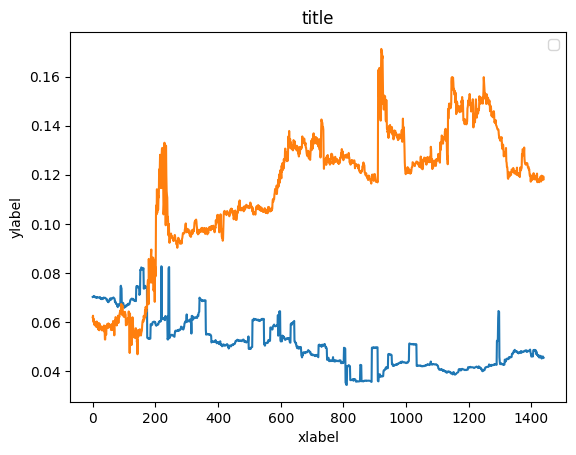

{'AUR-USD': (0.045450944, 0.17124519993701023)}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


           Open      High       Low     Close        Volume     1      2  \
0      0.026916  0.026964  0.026864  0.026964  1.000000e-09  True  False   
1      0.026938  0.029121  0.026938  0.029117  1.000000e-09  True  False   
2      0.029109  0.029109  0.026964  0.026964  1.000000e-09  True  False   
3      0.026954  0.026959  0.026908  0.026930  1.000000e-09  True  False   
4      0.026840  0.026840  0.026490  0.026490  1.000000e-09  True  False   
...         ...       ...       ...       ...           ...   ...    ...   
17423  0.045356  0.045653  0.045356  0.045631  1.000000e+00  True  False   
17424  0.045641  0.045948  0.045641  0.045913  1.000000e-09  True  False   
17425  0.045913  0.046120  0.045808  0.045961  1.000000e-09  True  False   
17426  0.045957  0.046186  0.045451  0.045595  1.000000e-09  True  False   
17427  0.045357  0.045712  0.045230  0.045653  1.000000e-09  True  False   

           3      4      5  ...     15     16     17     18     19     20  \
0      Fal

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, None, 1024)          │         617,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 1500)                │      15,150,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ (None, 1, 1500)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Multi-Head (MultiHeadAttention)      │ (None, 1, 1500)             │       9,006,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 1, 1500)             │      18,006,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 1, 86)               │         129,086 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,908,558 (163.68 MB)

 Trainable params: 42,908,558 (163.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 388ms/step - custom_metric: -0.0094 - loss: 0.0147 - val_custom_metric: -0.0201 - val_loss: 0.0245 - learning_rate: 0.0020
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 331ms/step - custom_metric: -0.0028 - loss: 0.0022 - val_custom_metric: -0.0174 - val_loss: 0.0200 - learning_rate: 0.0020
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 332ms/step - custom_metric: -0.0021 - loss: 0.0016 - val_custom_metric: -0.0119 - val_loss: 0.0155 - learning_rate: 0.0020
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 328ms/step - custom_metric: -0.0018 - loss: 0.0014 - val_custom_metric: -0.0158 - val_loss: 0.0189 - learning_rate: 0.0020
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 327ms/step - custom_metric: -0.0016 - loss: 0.0013 - val_custom_metric: -0.0072 - val_loss: 0.0095 - learning_rate: 0.0020
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 328ms/step - custom_metric: -0.0017 - loss: 0.0013 - val_custom_metric: -0.0070 - val_loss: 0.0084 - learning_rate: 0.0020
Epoc

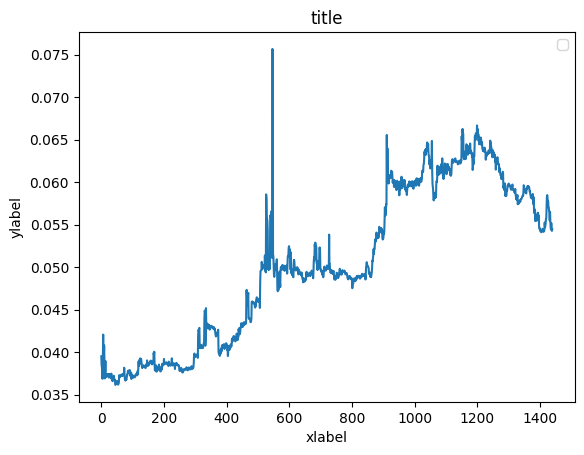

{'AUR-USD': (0.045652855, 0.07566439140431001)}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ZRO


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ZRO-BTC']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ZRO-BTC']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


ZRO


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ZRO-ETH']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ZRO-ETH']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


ZRO


[*********************100%***********************]  1 of 1 completed


          Open      High       Low     Close        Volume      1      2  \
0     0.001648  0.001663  0.001636  0.001663  1.000000e-09   True  False   
1     0.001657  0.001669  0.001657  0.001663  3.900000e+01   True  False   
2     0.001661  0.001664  0.001651  0.001651  1.000000e-09   True  False   
3     0.001648  0.001648  0.001640  0.001640  1.000000e-09   True  False   
4     0.001633  0.001633  0.001594  0.001594  1.000000e-09   True  False   
...        ...       ...       ...       ...           ...    ...    ...   
2416  0.001426  0.001426  0.001426  0.001426  1.000000e-09  False  False   
2417  0.001426  0.001426  0.001426  0.001426  1.000000e-09  False  False   
2418  0.001426  0.001426  0.001426  0.001426  1.000000e-09  False  False   
2419  0.001426  0.001426  0.001426  0.001426  1.000000e-09  False  False   
2420  0.001426  0.001426  0.001426  0.001426  1.000000e-09  False  False   

          3      4      5  ...     15     16     17     18     19     20  \
0     False

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, None, 1024)          │         567,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 1500)                │      15,150,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_2 (RepeatVector)       │ (None, 1, 1500)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Multi-Head (MultiHeadAttention)      │ (None, 1, 1500)             │       9,006,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 1, 1500)             │      18,006,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 1, 79)               │         118,579 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,847,875 (163.45 MB)

 Trainable params: 42,847,875 (163.45 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 351ms/step - custom_metric: nan - loss: nan - val_custom_metric: nan - val_loss: nan - learning_rate: 0.0020
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 328ms/step - custom_metric: nan - loss: nan - val_custom_metric: nan - val_loss: nan - learning_rate: 0.0020
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 310ms/step - custom_metric: nan - loss: nan - val_custom_metric: nan - val_loss: nan - learning_rate: 0.0020
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 330ms/step - custom_metric: nan - loss: nan - val_custom_metric: nan - val_loss: nan - learning_rate: 0.0020
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 321ms/step - custom_metric: nan - loss: nan - val_custom_metric: nan - val_loss: nan - learning_rate: 0.0020
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 317ms/step - custom_metric: nan - loss: nan - val_custom_metric: nan - val_loss: nan - learning_rate: 0.0020
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 321ms/step - custom_metric: nan - loss: nan - val_cu

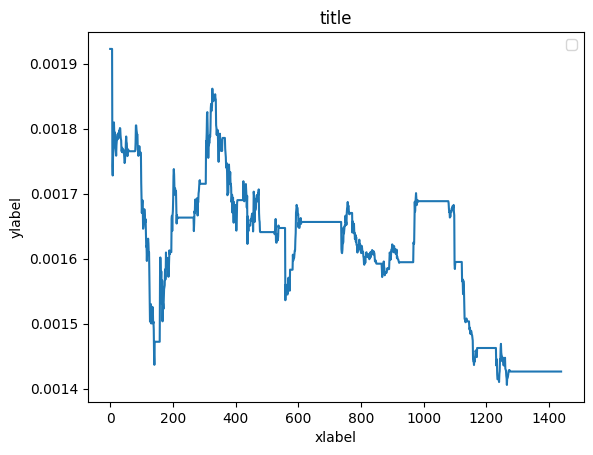

{'ZRO-USD': (0.0014263497, nan)}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


          Open      High       Low     Close        Volume      1      2  \
0     0.001657  0.001669  0.001657  0.001663  1.000000e-09   True  False   
1     0.001661  0.001664  0.001651  0.001651  1.000000e-09   True  False   
2     0.001648  0.001648  0.001640  0.001640  1.000000e-09   True  False   
3     0.001633  0.001633  0.001594  0.001594  1.000000e-09   True  False   
4     0.001594  0.001601  0.001587  0.001601  1.000000e-09   True  False   
...        ...       ...       ...       ...           ...    ...    ...   
2415  0.001426  0.001426  0.001426  0.001426  1.000000e-09  False  False   
2416  0.001426  0.001426  0.001426  0.001426  1.000000e-09  False  False   
2417  0.001426  0.001426  0.001426  0.001426  1.000000e-09  False  False   
2418  0.001426  0.001426  0.001426  0.001426  1.000000e-09  False  False   
2419  0.001426  0.001426  0.001426  0.001426  1.000000e-09  False  False   

          3      4      5  ...     15     16     17     18     19     20  \
0     False

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'ZRO_USD.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [14]:
import random
import os.path

dict_output = {}

for i in range(100):
  n = random.randint(0,len(cryptos))
  for j in ['BTC', 'ETH', 'USD']:
    #n = i
    print(cryptos[n])
    dict_output = {}
    dict_output = getStandardTesting(cryptos[n], j, dict_output, 24, 200, 1440)
    time.sleep(5)
    if os.path.exists("/content/train_validate_%s_%s.pdf" % (cryptos[n], j)):
      files.download("train_validate_%s_%s.pdf" % (cryptos[n], j))
    dict_output = {}
    dict_output = getFuturePrices(cryptos[n], j, dict_output, 24, 200, 1440)
    time.sleep(5)
    if os.path.exists("/content/forecasting_%s_%s.pdf" % (cryptos[n], j)):
      files.download("forecasting_%s_%s.pdf" % (cryptos[n], j))